## Diseño Evolutivo de Redes Neuronales Artificiales
## Baseline
Basado en el paper [Predicting Daily Returns of Global Stocks Indices: Neural Networks vs Support Vector Machines. Kaur, Dharni 2019](https://journaljemt.com/index.php/JEMT/article/view/30179)

Se desea reproducir los resultados del paper en ANN para el S&P 500.
Se usan datos diarios de cierre del S&P 500 (GSPC) obtenidos de Yahoo Finance.
Se calcularon los indicadores técnicos según las fórmulas del paper.

### Importar paquetes

In [0]:
import numpy as np
import sklearn.preprocessing as skp
import tensorflow as tf
from matplotlib import pyplot as plt


### Parámetros de configuración
La idea es agrupar aquí los parámetros configurables.

In [0]:
p = {
    "local_file": "baseline.csv",
    "url": "https://raw.githubusercontent.com/" +
           "jmacostap/webstore/master/baseline.csv",
    "cache_dir": "/content",
    "scaler": skp.MinMaxScaler(),
    "test_fraction": 0.20,  # 20% of samples for test data
    "neurons": 9,
    "activation": "sigmoid",  # for the hidden layer
    "output_activation": "linear",  # for the output layer
    "optimizer": tf.keras.optimizers.SGD(
        learning_rate=0.3,
        momentum=0.2,
        nesterov=False),
    "metrics": ["mae", "mape"],
    "loss": "mse",  # could be mae or mse
    "epochs": 500,  # training epochs
    "batch_size": 100,
    "shuffle": True,  # the training data
    "verbose": 0,  # verbose training
    }


### Leer los datos de entrada directamente del repositorio de GitHub

In [0]:
path_to_downloaded_file = tf.keras.utils.get_file(
    p["local_file"],
    p["url"],
    cache_dir=p["cache_dir"],
    )
data = np.loadtxt(path_to_downloaded_file, skiprows=1, delimiter=",")
print(f"{data.shape} samples read")

# Extract targets
targets = np.reshape(data[:, -1], (-1, 1))
print(f"Targets to be used: {targets.shape}")

# Extract features
data = data[:, :-1]
print(f"Samples to be used: {data.shape}")

# Normalize data to [0,1]
data_scaler = p["scaler"]
data = data_scaler.fit_transform(data)
targets_scaler = p["scaler"]
targets = targets_scaler.fit_transform(targets)

# Reserve test data
test_fraction = np.int(len(data)*p["test_fraction"])
print(f"Test fraction: {test_fraction}")
train_targets = targets[:-test_fraction]
print(f"Train targets: {train_targets.shape}")
train_data = data[:-test_fraction]
print(f"Train samples: {train_data.shape}")
test_targets = targets[-test_fraction:]
print(f"Test targets: {test_targets.shape}")
test_data = data[-test_fraction:]
print(f"Test samples: {test_data.shape}")

917504/913354 [==============================] - 0s 0us/step
(3022, 20) samples read
Targets to be used: (3022, 1)
Samples to be used: (3022, 19)
Test fraction: 604
Train targets: (2418, 1)
Train samples: (2418, 19)
Test targets: (604, 1)
Test samples: (604, 19)


### Crear el modelo

In [0]:
# Ensure reproducibility
np.random.seed(31416)  # numpy
tf.random.set_seed(31416)  # keras

# Define the model
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(
            p["neurons"],
            activation=p["activation"],
            input_shape=(data.shape[1],),
        ),
        tf.keras.layers.Dense(
            1,
            activation=p["output_activation"],
        ),
    ]
)

# Create the model
model.compile(
    optimizer=p["optimizer"],
    metrics=p["metrics"],
    loss=p["loss"],
)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 9)                 180       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10        
Total params: 190
Trainable params: 190
Non-trainable params: 0
_________________________________________________________________
None


### Entrenar el modelo

In [0]:
# Train the model
history = model.fit(
    train_data,
    train_targets,
    epochs=p["epochs"],
    batch_size=p["batch_size"],
    shuffle=p["shuffle"],
    verbose=p["verbose"],
    validation_split=p["test_fraction"],
    )
loss_error, mae_error, mape_error = model.evaluate(train_data, train_targets)
print(f"Test error: {loss_error}, MAE: {mae_error}, MAPE: {mape_error}")

2418/2418 [==============================] - 1s 359us/sample - loss: 7.5247e-04 - mae: 0.0171 - mape: 111317.8125
Test error: 0.0007524652791206052, MAE: 0.017124058678746223, MAPE: 111317.8125


### Visualizar el entrenamiento

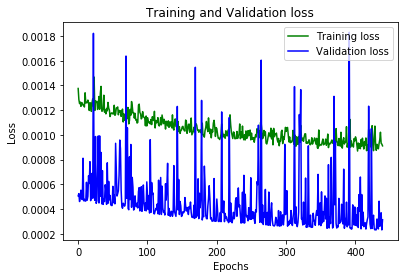

In [0]:
fro = 60  # Avoid autoscale issues
plt.plot(history.history['loss'][fro:], 'g', label='Training loss')
plt.plot(history.history['val_loss'][fro:], 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Probar el modelo con los datos de prueba

In [0]:
loss_error, mae_error, mape_error = model.evaluate(test_data, test_targets)
print(f"Test error: {loss_error}, MAE: {mae_error}, MAPE: {mape_error}")

604/604 [==============================] - 0s 379us/sample - loss: 7.1445e-04 - mae: 0.0225 - mape: 5.1617
Test error: 0.0007144540859793393, MAE: 0.0224679596722126, MAPE: 5.161745548248291
